In [1]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# ignorer les warnings inutiles (voir SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os
import tarfile
from six.moves import urllib
import pandas as pd

EMPLOYEES_PATH = os.path.join("datasets", "employees")
TILME_PATH = os.path.join("datasets", "time")

def load_general_data(employees_path=EMPLOYEES_PATH):
    general_csv_path = os.path.join(employees_path, "general_data.csv")
    return pd.read_csv(general_csv_path)

def load_employees_data(employees_path=EMPLOYEES_PATH):
    employee_csv_path = os.path.join(employees_path, "employee_survey_data.csv")
    return pd.read_csv(employee_csv_path)

def load_manager_data(employees_path=EMPLOYEES_PATH):
    manager_csv_path = os.path.join(employees_path, "manager_survey_data.csv")
    return pd.read_csv(manager_csv_path)

def load_time_in_data(time_path=TILME_PATH):
    time_in_csv_path = os.path.join(time_path, "in_time.csv")
    return pd.read_csv(time_in_csv_path)

def load_time_out_data(time_path=TILME_PATH):
    time_out_csv_path = os.path.join(time_path, "out_time.csv")
    return pd.read_csv(time_out_csv_path)

# Loading all the data
general_df = load_general_data()
employees_df = load_employees_data()
manager_df = load_manager_data()
time_in_df = load_time_in_data()
time_out_df = load_time_out_data()

# Add EmployeeID column name
time_in_df.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
time_out_df.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )

# Transform True/False string to 1:0
general_df['Attrition'] = general_df['Attrition'].map({'Yes': 1, 'No': 0})

# Merging surveys and general dataframes
merged_df = pd.merge(general_df, employees_df, on='EmployeeID')
merged_df = pd.merge(merged_df, manager_df, on='EmployeeID')

merged_df["GlobalSatisfaction"] = (merged_df["EnvironmentSatisfaction"] + merged_df["JobSatisfaction"] + merged_df["WorkLifeBalance"]) / 3
merged_df["GlobalPerformance"] = (merged_df["JobInvolvement"] + merged_df["PerformanceRating"]) / 2

C:\Users\amaturel\AppData\Local\Temp\ipykernel_23100\2889711764.py:26: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Convert string columns to datetime, handling None as NaT automatically
for col in time_in_df.columns[1:]:  # Skip 'EmployeeID' column
    time_in_df[col] = pd.to_datetime(time_in_df[col], errors='coerce')
    time_out_df[col] = pd.to_datetime(time_out_df[col], errors='coerce')

# Initialize a DataFrame to store the difference between in and out time
time_diff_df = time_in_df.copy()
for col in time_in_df.columns[1:]:  # Again, skip 'EmployeeID'
    time_diff_df[col] = time_out_df[col] - time_in_df[col]
    # Replace NaT with timedelta of zero
    time_diff_df[col] = time_diff_df[col].fillna(pd.Timedelta(seconds=0))

df_converted = time_diff_df.apply(lambda x: x.dt.total_seconds() / 3600 if x.dtype == 'timedelta64[ns]' else x)

# Calculate the sum of work durations for each employee
total_duration = df_converted.drop(columns='EmployeeID').sum(axis=1)
total_variance = df_converted.drop(columns='EmployeeID').var(axis=1)
total_absence = df_converted.drop(columns='EmployeeID').isin([0]).sum(axis=1)

# Calculate the number of datetime columns without the EmployeeID column
num_datetime_columns = len(time_diff_df.columns) - 1

# Calculate the average presence time per employee
average_presence_time = total_duration / num_datetime_columns
average_variance = total_variance / num_datetime_columns
absence = total_absence

# Attach the results to the original EmployeeID
average_presence_df = pd.DataFrame({
    'EmployeeID': time_diff_df['EmployeeID'],
    'AveragePresence': average_presence_time,
    'VariancePresence': average_variance
})

merged_df = merged_df.merge(average_presence_df, left_on='EmployeeID', right_on='EmployeeID')

merged_df.describe()

,Age,Attrition,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,GlobalSatisfaction,GlobalPerformance,AveragePresence,VariancePresence
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,...,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4327.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,0.161224,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,...,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741,2.737000,2.941837,6.978070,0.020002
std,9.133301,0.367780,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,...,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742,0.568256,0.400536,1.269584,0.007253
min,18.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,5.167828,0.008247
25%,30.000000,0.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.333333,2.500000,5.990699,0.014807
50%,36.000000,0.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.666667,3.000000,6.688821,0.018418
75%,43.000000,0.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,...,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.333333,3.000000,7.537530,0.023469
max,60.000000,1.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,...,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.434399,0.048186


In [3]:
unethical_cols = ["Age", "MaritalStatus", "Gender", "EmployeeID"]
merged_df = merged_df.drop(unethical_cols, axis=1)

In [4]:
data = merged_df.drop(["Attrition"], axis=1)
data_labels = merged_df["Attrition"].copy()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_correlated_cols = ["AveragePresence", "VariancePresence"]

general_numerical = data.select_dtypes(include=[np.number])
#general_numerical = general_numerical.drop(num_correlated_cols, axis=1)
numerical_attribs = list(general_numerical)

general_gategoric = data.select_dtypes(include=[object])
categoric_attribs = list(general_gategoric)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
        ('ordinal', OrdinalEncoder()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_attribs),
        ("cat", cat_pipeline, categoric_attribs)
    ],
    remainder='passthrough')

data_prepared = full_pipeline.fit_transform(data)

In [5]:
data_df = pd.DataFrame(data_prepared, columns=data.columns)
data_prepared_df = data_df.copy()

data_prepared_df = pd.concat([data_labels, data_prepared_df], axis=1)

In [6]:
X = data_prepared_df.drop("Attrition", axis=1)  # Features
y = data_prepared_df["Attrition"]  # Labels

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train, test in splitter.split(X, y):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

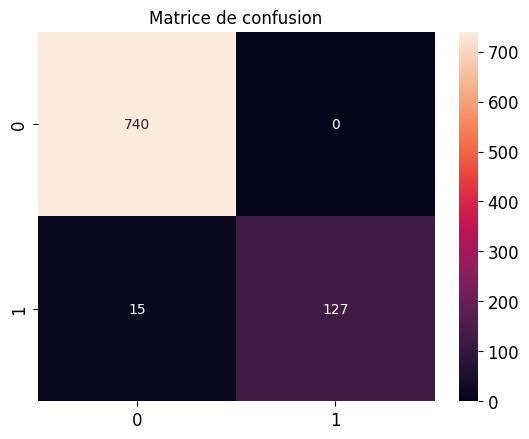

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, roc_curve, confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.show()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       740
           1       1.00      0.89      0.94       142

    accuracy                           0.98       882
   macro avg       0.99      0.95      0.97       882
weighted avg       0.98      0.98      0.98       882



In [10]:
y_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities of the positive class

auc_score = roc_auc_score(y_test, y_proba)
auc_score

0.9951037304910545

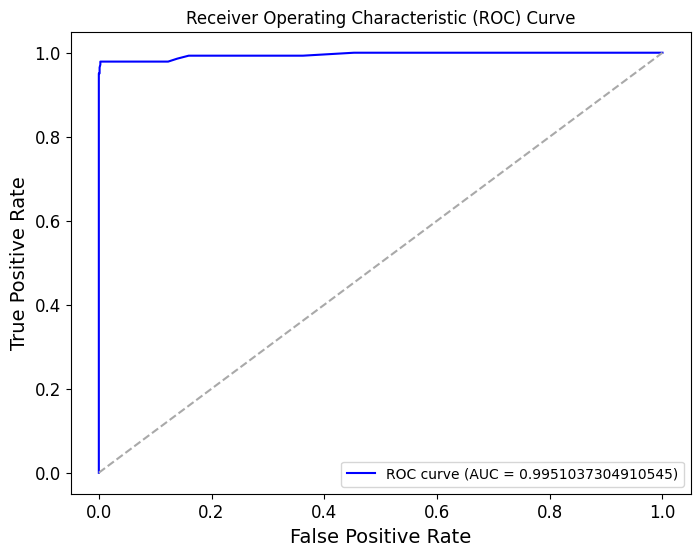

In [11]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

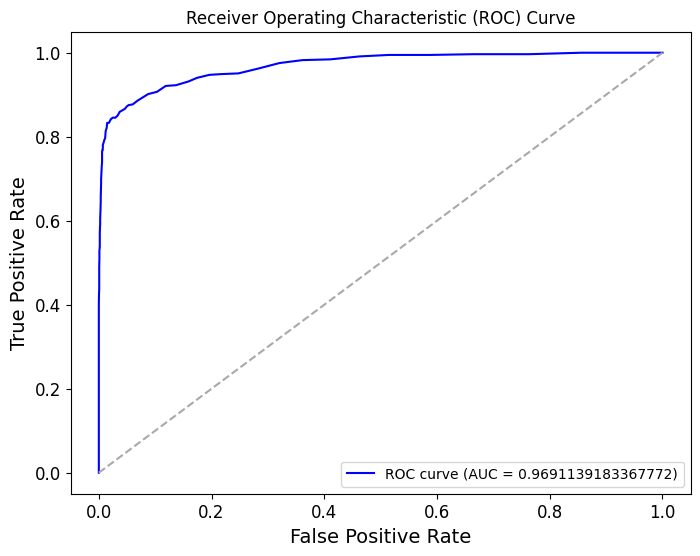

In [12]:
from sklearn.model_selection import cross_val_predict

y_probas_forest = cross_val_predict(clf, X_train, y_train, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores_forest)

auc_score = roc_auc_score(y_train, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
clf_test = RandomForestClassifier()

clf_test.fit(X_train, y_train)

# Predict on training set
train_predictions_tr = clf_test.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions_tr)

# Predict on test set
test_predictions_te = clf_test.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions_te)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9886621315192744


In [14]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(clf_test, X, y, cv=5, scoring='accuracy')

print(f"Cross-validated scores: {scores}")
print(f"Mean CV Accuracy: {scores.mean()}")

Cross-validated scores: [0.99546485 0.99319728 0.99319728 0.99546485 0.99433107]
Mean CV Accuracy: 0.994331065759637


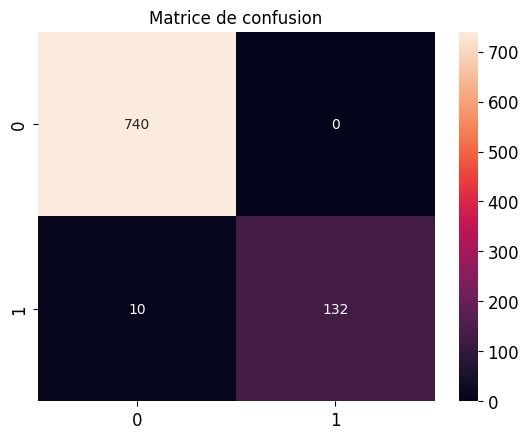

In [15]:
conf_mat = confusion_matrix(y_test, test_predictions_te)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.show()

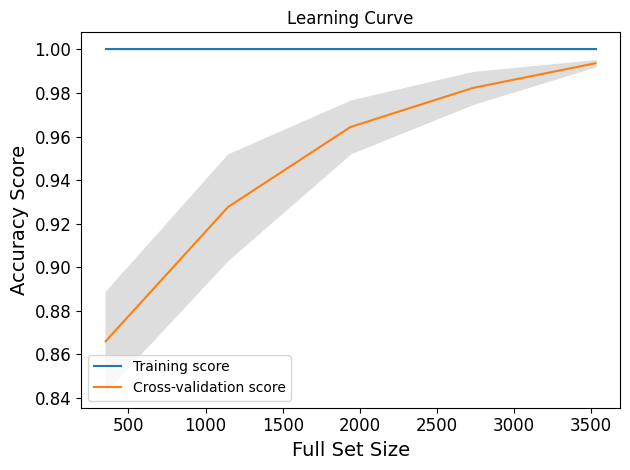

In [16]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Full Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [17]:
# Get feature importance
importances = clf.feature_importances_

# To map these importances to the correct feature names:
feature_names = X_train.columns
feature_importances = sorted(zip(importances, feature_names), reverse=True)

print("Feature importances:")
for importance, name in feature_importances:
    print(f"{name}: {importance}")

Feature importances:
WorkLifeBalance: 0.10009124526032387
NumCompaniesWorked: 0.0909726912504914
EducationField: 0.07884967855355582
JobInvolvement: 0.06063737898038894
PercentSalaryHike: 0.05891274362095111
BusinessTravel: 0.0510661304537145
EnvironmentSatisfaction: 0.04813301342066843
JobLevel: 0.045340024858397
StockOptionLevel: 0.04348260770799483
EmployeeCount: 0.041900499507725314
AveragePresence: 0.03993786333211124
StandardHours: 0.032797043059054086
TotalWorkingYears: 0.03169303842581492
Over18: 0.03096376190764628
GlobalPerformance: 0.028244461140921988
Department: 0.027920446774903303
TrainingTimesLastYear: 0.027555570896788187
YearsAtCompany: 0.027514706566716254
Education: 0.025050886976534365
MonthlyIncome: 0.02460443642199084
JobSatisfaction: 0.021525313234918443
GlobalSatisfaction: 0.020307112720377992
YearsSinceLastPromotion: 0.01847893459112606
PerformanceRating: 0.0182015275518016
YearsWithCurrManager: 0.005818882785083305
VariancePresence: 0.0
JobRole: 0.0
DistanceF

In [18]:
from sklearn.inspection import permutation_importance

# Assuming clf is your trained model and X_test, y_test are your test datasets
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

sorted_importances = sorted(zip(result.importances_mean, X_test.columns), reverse=True)
print("Permutation Feature Importances:")
for importance, name in sorted_importances:
    print(f"{name}: {importance}")

Permutation Feature Importances:
WorkLifeBalance: 0.06587301587301586
NumCompaniesWorked: 0.03956916099773241
EnvironmentSatisfaction: 0.026870748299319725
PercentSalaryHike: 0.018820861678004508
EmployeeCount: 0.018480725623582762
TotalWorkingYears: 0.0178004535147392
EducationField: 0.0159863945578231
StockOptionLevel: 0.01587301587301586
StandardHours: 0.01553287981859407
AveragePresence: 0.012925170068027191
TrainingTimesLastYear: 0.011904761904761885
JobLevel: 0.011564625850340127
BusinessTravel: 0.01099773242630383
JobInvolvement: 0.007256235827664381
YearsAtCompany: 0.006575963718820821
Department: 0.00419501133786847
GlobalPerformance: 0.0038548752834466904
YearsSinceLastPromotion: 0.0037414965986394266
Over18: 0.003628117913832163
JobSatisfaction: 0.003628117913832163
MonthlyIncome: 0.0036281179138321516
PerformanceRating: 0.0034013605442176687
GlobalSatisfaction: 0.0023809523809523504
Education: 0.0015873015873015372
YearsWithCurrManager: 0.0
VariancePresence: 0.0
JobRole: 0.

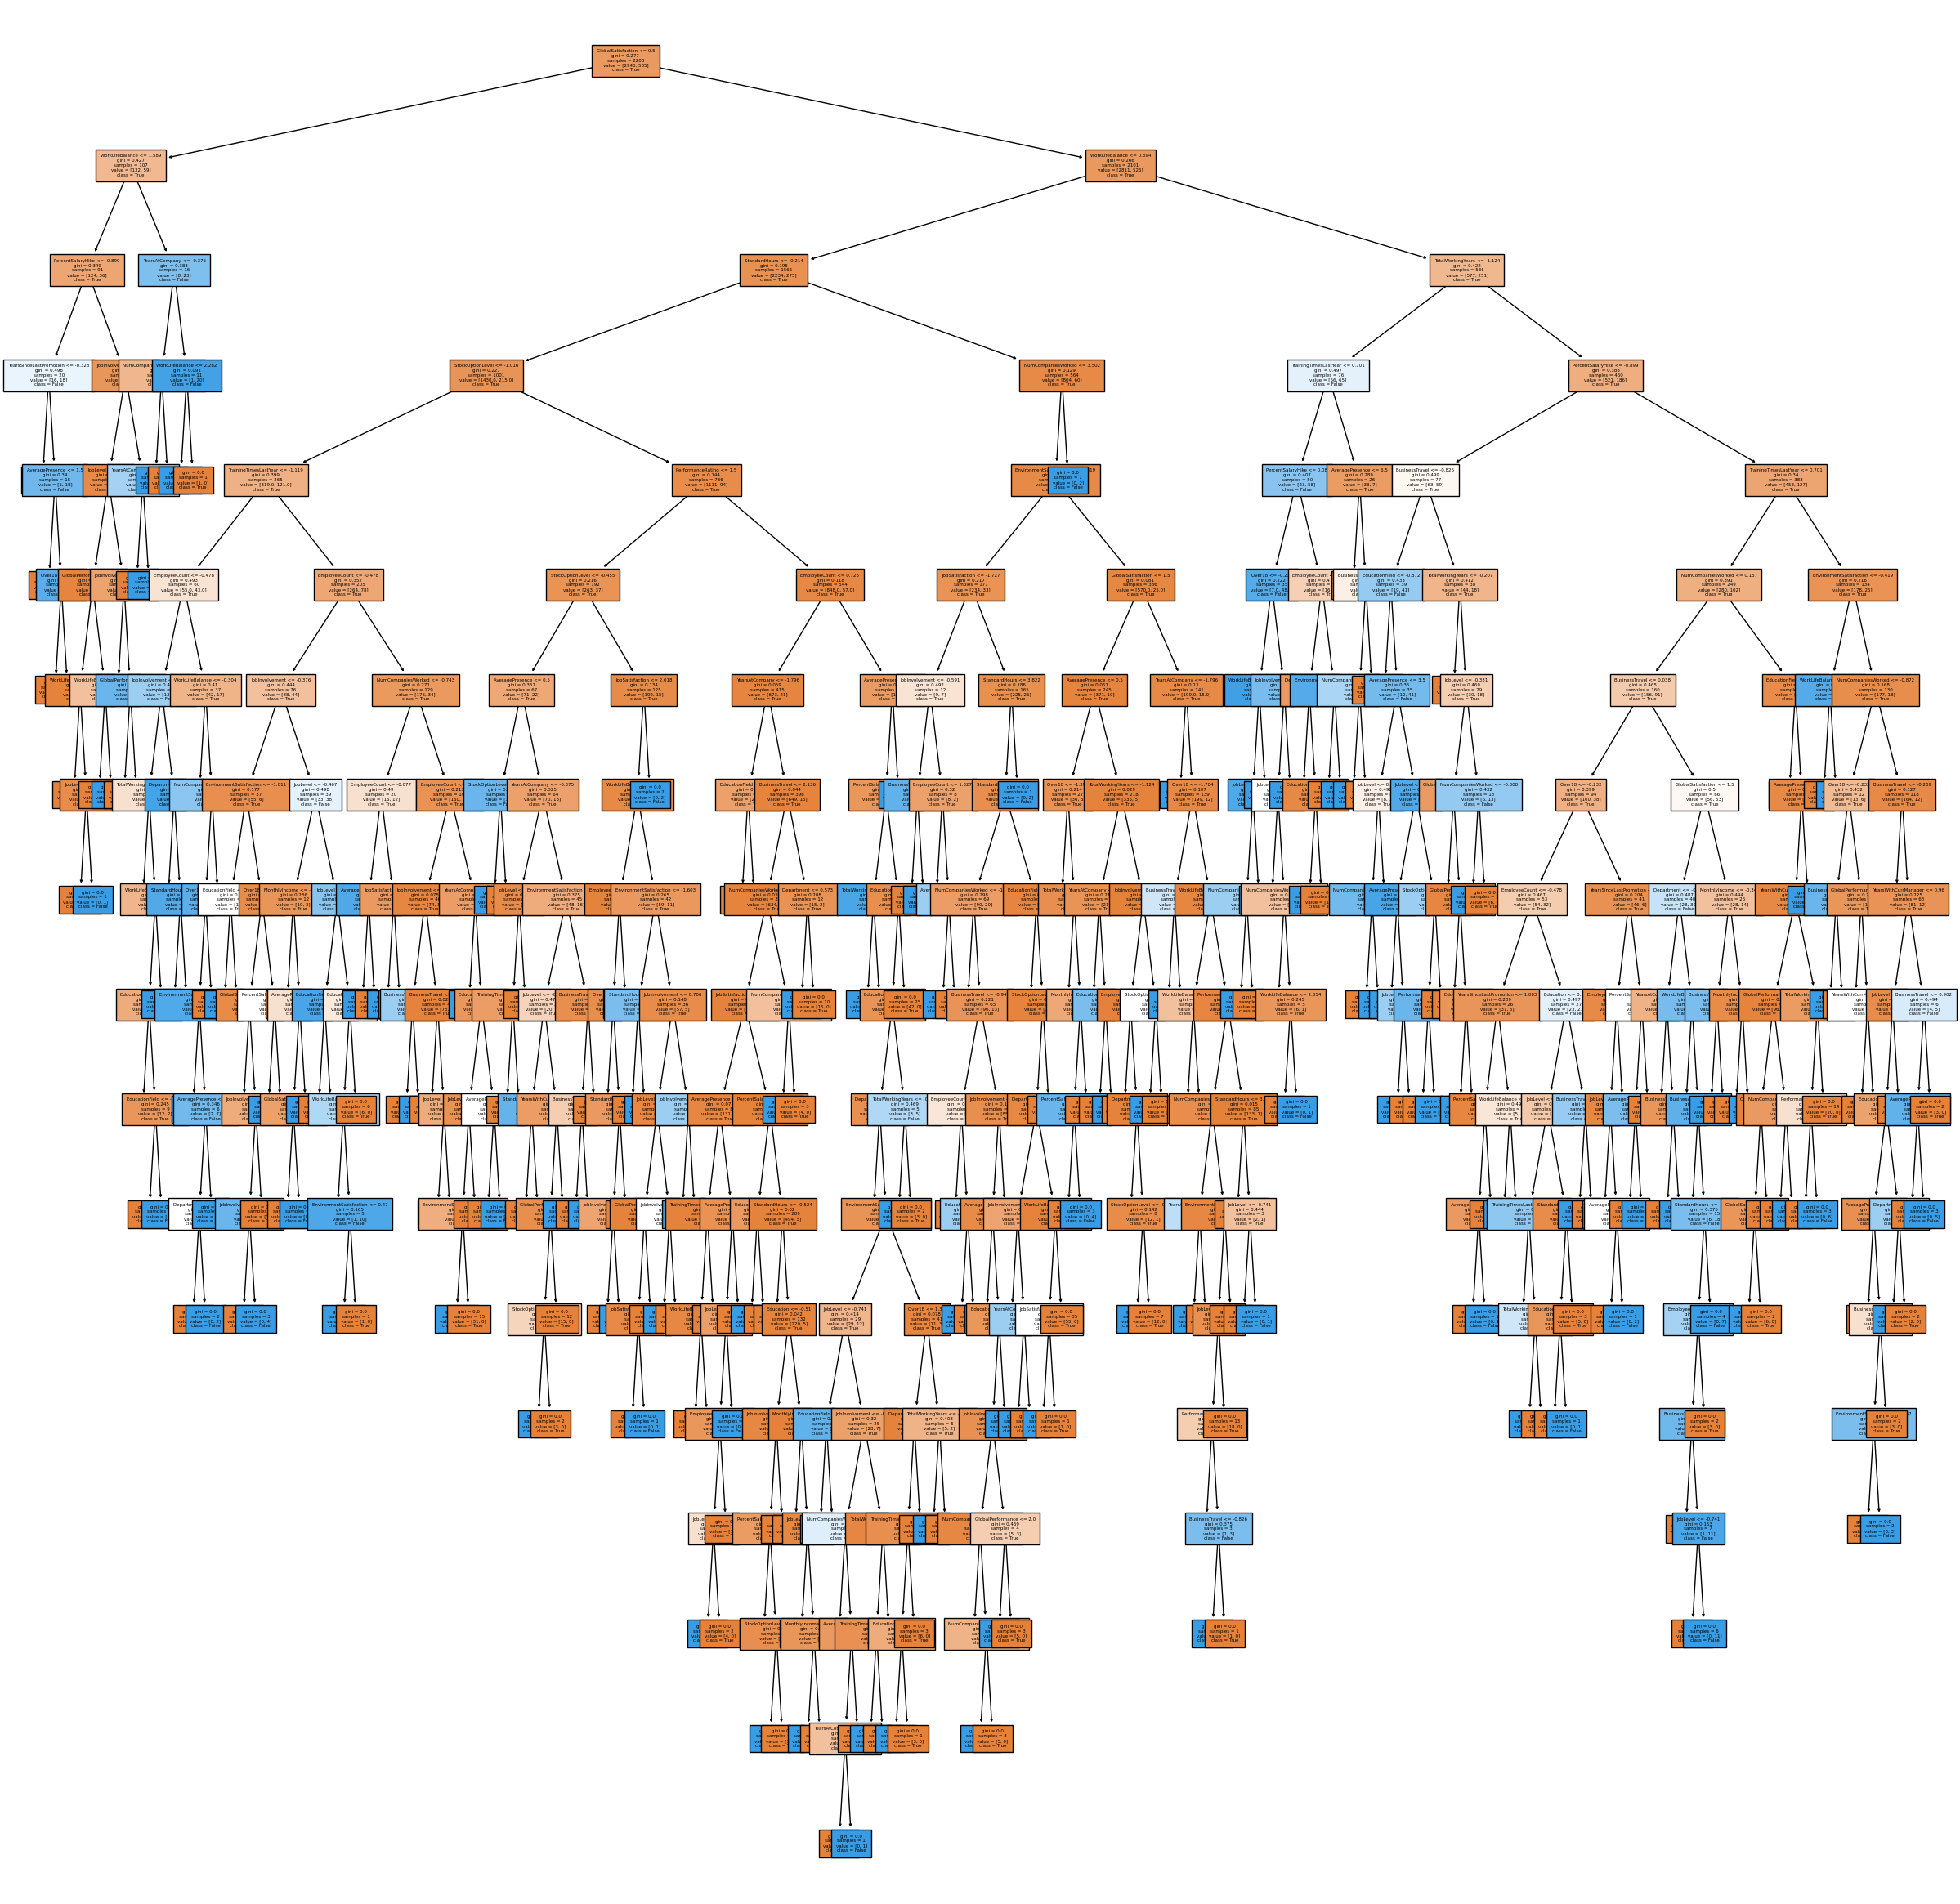

In [19]:
fn = X_train.columns
cn = ["True", "False"]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,30))

from sklearn.tree import plot_tree

plot_tree(clf.estimators_[21],
           feature_names = fn, 
           class_names=cn,
           filled = True,fontsize=4);

In [21]:
filtered_out = merged_df[merged_df['Attrition'] == 1]
filtered_out[:20].describe()

,Attrition,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,GlobalSatisfaction,GlobalPerformance,AveragePresence,VariancePresence
count,20.0,20.000000,20.000000,20.0,20.000000,20.00000,20.00000,20.000000,20.0,20.000000,...,20.000000,20.000000,19.000000,20.000000,20.000000,20.000000,19.000000,20.000000,20.000000,20.000000
mean,1.0,9.100000,2.300000,1.0,1.900000,62637.00000,2.50000,15.900000,8.0,0.950000,...,2.700000,2.350000,2.631579,2.550000,2.500000,3.250000,2.491228,2.875000,7.870316,0.025155
std,0.0,7.893368,0.978721,0.0,1.165287,42605.18119,2.50263,4.339537,0.0,0.825578,...,2.921787,1.225819,0.955134,0.759155,0.688247,0.444262,0.641838,0.358175,1.509803,0.009538
min,1.0,1.000000,1.000000,1.0,1.000000,11290.00000,0.00000,11.000000,8.0,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.666667,2.500000,5.283144,0.014267
25%,1.0,3.750000,1.750000,1.0,1.000000,38442.50000,1.00000,12.000000,8.0,0.000000,...,0.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.500000,6.689458,0.018813
50%,1.0,8.000000,2.000000,1.0,1.500000,55890.00000,1.50000,14.000000,8.0,1.000000,...,2.000000,3.000000,3.000000,3.000000,2.500000,3.000000,2.333333,3.000000,7.904555,0.021244
75%,1.0,10.250000,3.000000,1.0,2.250000,70180.00000,3.25000,19.250000,8.0,1.000000,...,4.000000,3.000000,3.000000,3.000000,3.000000,3.250000,3.000000,3.000000,9.222231,0.030876
max,1.0,29.000000,4.000000,1.0,5.000000,178750.00000,9.00000,25.000000,8.0,3.000000,...,9.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.666667,3.500000,10.220511,0.044502


In [22]:
filtered_noout = merged_df[merged_df['Attrition'] == 0]
filtered_noout[:20].describe()

,Attrition,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,GlobalSatisfaction,GlobalPerformance,AveragePresence,VariancePresence
count,20.0,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,...,20.000000,19.000000,20.000000,20.000000,20.000000,20.000000,19.000000,20.000000,20.000000,20.000000
mean,0.0,8.450000,3.100000,1.0,1.950000,65291.500000,1.900000,14.450000,8.0,1.050000,...,4.750000,2.631579,2.700000,2.600000,2.750000,3.150000,2.614035,2.950000,7.006450,0.020552
std,0.0,7.323179,1.071153,0.0,1.099043,46791.387565,1.774082,3.845366,0.0,1.234376,...,3.711646,1.116071,1.218282,0.820783,0.444262,0.366348,0.705036,0.276253,1.321439,0.007992
min,0.0,1.000000,1.000000,1.0,1.000000,20440.000000,0.000000,11.000000,8.0,0.000000,...,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.666667,2.500000,5.364011,0.010389
25%,0.0,1.750000,2.750000,1.0,1.000000,30052.500000,1.000000,11.750000,8.0,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.750000,3.000000,2.000000,3.000000,6.243062,0.014368
50%,0.0,7.500000,3.000000,1.0,2.000000,47795.000000,1.000000,13.000000,8.0,0.500000,...,4.000000,3.000000,2.500000,3.000000,3.000000,3.000000,2.666667,3.000000,6.514985,0.019080
75%,0.0,11.750000,4.000000,1.0,2.250000,86575.000000,3.000000,16.250000,8.0,2.000000,...,7.000000,3.500000,4.000000,3.000000,3.000000,3.000000,3.166667,3.000000,7.576416,0.023079
max,0.0,28.000000,5.000000,1.0,4.000000,193280.000000,7.000000,23.000000,8.0,3.000000,...,13.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.666667,3.500000,10.381321,0.037758
